# CIFAR Conv Net

И так, в этом ноутбуке Вы сделаете превую в своей жизни сверточную сеть! На сложном датасете. Cкачайте его кстати, 

In [ ]:
!mkdir cifar10
!curl -o cifar-10-python.tar.gz https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar -xvzf cifar-10-python.tar.gz -C cifar10

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from cifar3 import load_CIFAR10
plt.rcParams['figure.figsize'] = (10.0, 8.0) 

cifar10_dir = './cifar10/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

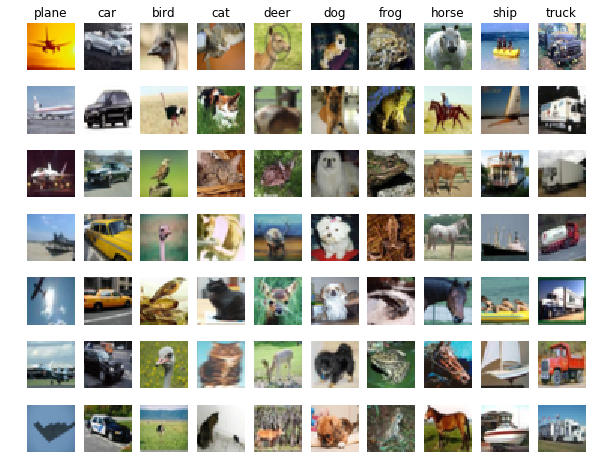

In [3]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8').transpose(1, 2, 0))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

<h1 align="center">First of all -- Checking Questions</h1> 

**Вопрос 1**: Чем отличаются современные сверточные сети от сетей 5 летней давности?

Значительно больше слоёв (152 у ResNet и 22 у GoogleNet против 8 и менее слоёв у старых сетей), соответственно более сложная архитектура с использованием новых техник (например, shortcuts при распространении ошибок), продвинутые методы оптимизации (например, adam). Как следствие, сильно улучшается качество предсказания.

**Вопрос 2**: Какие неприятности могут возникнуть во время обучения современных нейросетей?

Поскольку в современных нейросетях много слоёв, у них очень много настраиваемых параметров, и не всегда понятно, какие нужно изменить для улучшения предсказания. Бывает сложно контролировать недообучение, переобучение, ошибки в процессе обучения. Обучение бывает долгим по времени, данные занимают много памяти, так что для эффективного обучения требуются большие вычислительные мощности, иногда достигаемые лишь на специализированном оборудовании. 

**Вопрос 3**: У вас есть очень маленький датасет из 100 картинок, классификация, но вы очень хотите использовать нейросеть, какие неприятности вас ждут и как их решить? что делать если первый вариант  решения не заработает?

Очевидная возможность переобучения на данном сете. Можно применять стандартные методики борьбы с переобучением, регуляризации: дропаут, нормализацию батчей, регуляризацию весов. Можно сделать бутстреп из исходного сета, получать новые картинки из имеющихся путём вращения (rotation), масштабирования, добавления шума. Вероятно, имеет смысл сделать больше свёрток, чтобы выжать из изображений максимум информации об их деталях.

**Вопрос 4**: Как сделать стайл трансфер для музыки? oO

Стратегия, видимо, такая же, как для изображений: штрафовать за разницу между значениями в разных точках, чтобы получить не зависящие от положения признаки, которые и будут характеризовать стиль. Также штрафовать за разницу полученного и исходного объектов, чтобы сохранить "очертания". Таким образом, минимизируем сумму двух функций потерь. Представлять музыку в виде спектрограмм (short time Fourier transform): двумерный массив, где по вертикали частоты, по горизонтали время. Это позволяет работать с аудиозаписями в точности как с изображениями: спектрограмма сама по себе уже является изображением с одним каналом. Однако, спектр (вертикальная ось) следует сохранить в нетронутом виде (именно он определет звучание в каждый момент времени, то есть целиком отвечает за "стиль"), то есть свёртки будут одномерными, только по времени. Стиль, соответственно, понимается как некоторая не зависящая от времени спектральная характеристика музыки. 

In [12]:
import lasagne
from theano import tensor as T
from lasagne.nonlinearities import *

input_X = T.tensor4("X")
target_y = T.vector("target Y integer",dtype='int64')

### Соберите нейронку: 
- Many times x (Conv+Pool)
- Many small convolutions like 3x3
- Batch Norm 
- Residual Connection
- Data Augmentation 
- Learning rate Schedule 
- ...

### Для вдохновения 
- http://torch.ch/blog/2015/07/30/cifar.html
- https://github.com/szagoruyko/wide-residual-networks 

### Самое интересное
- Для сдачи задания нужно набрать на точность тесте > **92.5**% (это займет много времени, торопитесь :) )
- Для получения бонусных баллов > **95.0**%
- Будет очень хорошо если вы придумаете свою архитектуру или сможете обучить что-то из вышеперечисленного :)
- А для обучения всего этого добра вам будет куда удобнее использовать GPU на Amazon 
    - Инструкция https://github.com/persiyanov/ml-mipt/tree/master/amazon-howto 
    - Вам помогут tmux, CuDNN, ssh tunnel, nvidia-smi, ... 
    - Have fun :)

In [38]:
net = lasagne.layers.InputLayer(shape=(None, 3, 32, 32), input_var=input_X)

net = lasagne.layers.Conv2DLayer(net, 64, 3, pad='same', W=lasagne.init.HeNormal())
net = lasagne.layers.Conv2DLayer(net, 64, 3, pad='same', W=lasagne.init.HeNormal(), nonlinearity=rectify)
net = lasagne.layers.MaxPool2DLayer(net, 2)
net = lasagne.layers.BatchNormLayer(net)
net = lasagne.layers.Conv2DLayer(net, 96, 3, pad='same', W=lasagne.init.HeNormal())
net = lasagne.layers.Conv2DLayer(net, 96, 3, pad='same', W=lasagne.init.HeNormal(), nonlinearity=rectify)
net = lasagne.layers.MaxPool2DLayer(net, 2)
net = lasagne.layers.BatchNormLayer(net)
net = lasagne.layers.Conv2DLayer(net, 128, 3, pad='same', W=lasagne.init.HeNormal())
net = lasagne.layers.Conv2DLayer(net, 128, 3, pad='same', W=lasagne.init.HeNormal(), nonlinearity=rectify)
net = lasagne.layers.MaxPool2DLayer(net, 2)
net = lasagne.layers.BatchNormLayer(net)
net = lasagne.layers.DenseLayer(net, num_units=256, W=lasagne.init.HeNormal(), nonlinearity=rectify)
net = lasagne.layers.DropoutLayer(net)
net = lasagne.layers.DenseLayer(net, num_units=128, W=lasagne.init.HeNormal(), nonlinearity=rectify)
net = lasagne.layers.DropoutLayer(net)

net = lasagne.layers.DenseLayer(net,num_units = 10, nonlinearity=softmax)

In [39]:
y_predicted = lasagne.layers.get_output(net)
all_weights = lasagne.layers.get_all_params(net, trainable=True)
print(all_weights)

[W, b, W, b, beta, gamma, W, b, W, b, beta, gamma, W, b, W, b, beta, gamma, W, b, W, b, W, b]


In [40]:
loss = lasagne.objectives.categorical_crossentropy(y_predicted, target_y).mean()
accuracy = lasagne.objectives.categorical_accuracy(y_predicted, target_y).mean()
adam_ = lasagne.updates.adam(loss, all_weights)

In [41]:
train_fun = theano.function([input_X,target_y],[loss, accuracy], updates=adam_)
accuracy_fun = theano.function([input_X,target_y],accuracy)

### Вот и всё, пошли её учить

In [42]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

# Процесс обучения

In [44]:
import time

num_epochs = 10 #количество проходов по данным

batch_size = 50 #размер мини-батча

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    i = 0
    for batch in iterate_minibatches(X_train, y_train,batch_size):
        i += 1
        if(i % 100 == 0):
            print(i,"/ 1000")
        inputs, targets = batch
        train_err_batch, train_acc_batch= train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_test, y_test, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(val_acc / val_batches * 100))

100 / 1000
200 / 1000
300 / 1000
400 / 1000
500 / 1000
600 / 1000
700 / 1000
800 / 1000
900 / 1000
1000 / 1000
Epoch 1 of 10 took 2475.775s
  training loss (in-iteration):		1.594561
  train accuracy:		42.26 %
  validation accuracy:		56.19 %
100 / 1000
200 / 1000
300 / 1000
400 / 1000
500 / 1000
600 / 1000
700 / 1000
800 / 1000
900 / 1000
1000 / 1000
Epoch 2 of 10 took 2448.974s
  training loss (in-iteration):		1.098973
  train accuracy:		62.33 %
  validation accuracy:		67.12 %
100 / 1000
200 / 1000
300 / 1000
400 / 1000
500 / 1000
600 / 1000
700 / 1000
800 / 1000
900 / 1000
1000 / 1000
Epoch 3 of 10 took 2496.393s
  training loss (in-iteration):		0.876934
  train accuracy:		70.65 %
  validation accuracy:		72.28 %
100 / 1000
200 / 1000
300 / 1000
400 / 1000
500 / 1000
600 / 1000
700 / 1000
800 / 1000
900 / 1000
1000 / 1000
Epoch 4 of 10 took 2500.618s
  training loss (in-iteration):		0.740015
  train accuracy:		75.49 %
  validation accuracy:		75.31 %
100 / 1000
200 / 1000
300 / 1000
400

In [45]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

if test_acc / test_batches * 100 > 92.5:
    print("Achievement unlocked: колдун 80 уровня")
else:
    print("Нужно больше магии!")

Final results:
  test accuracy:		80.10 %
Нужно больше магии!


## Заполните форму

https://goo.gl/forms/EeadABISlVmdJqgr2 

In [20]:
len(range(0, len(X_train) - 50 + 1, 50))

1000